In [ ]:
path = "data/garbage-classification-v2/garbage-dataset"

print("Path to dataset files:", path)

 > [System] Locked to GPU Device 0: Tesla T4
 > [System] Total VRAM: 14.74 GB
 > [System] Random Seed Locked to 42
 > Feature Extractors initialized
 > Total images: 19762. Starting extraction...
Batch 20/20...
Extraction complete (56.67s). Transferring to CPU...
Data Saved: LBP Shape (19762, 768), HOG Shape (19762, 10800)

>>> Processing: SVM + LBP
 > [VRAM Strategy] Loading data to GPU...
 > [Pipeline] GPU Oversampling (Train Only)...
 > [Pipeline] Standard Scaling...
 > [Pipeline] Skipping PCA for SVM (Using Raw Features)
 > Training model... (Data Shape: (42610, 768))
 > Inferencing...
 > Accuracy: 0.76777131
              precision    recall  f1-score   support

       metal       0.68      0.57      0.62       204
     battery       0.79      0.76      0.77       189
  biological       0.73      0.75      0.74       199
   cardboard       0.82      0.75      0.78       365
       trash       0.70      0.57      0.63       189
     clothes       0.90      0.97      0.94      1066


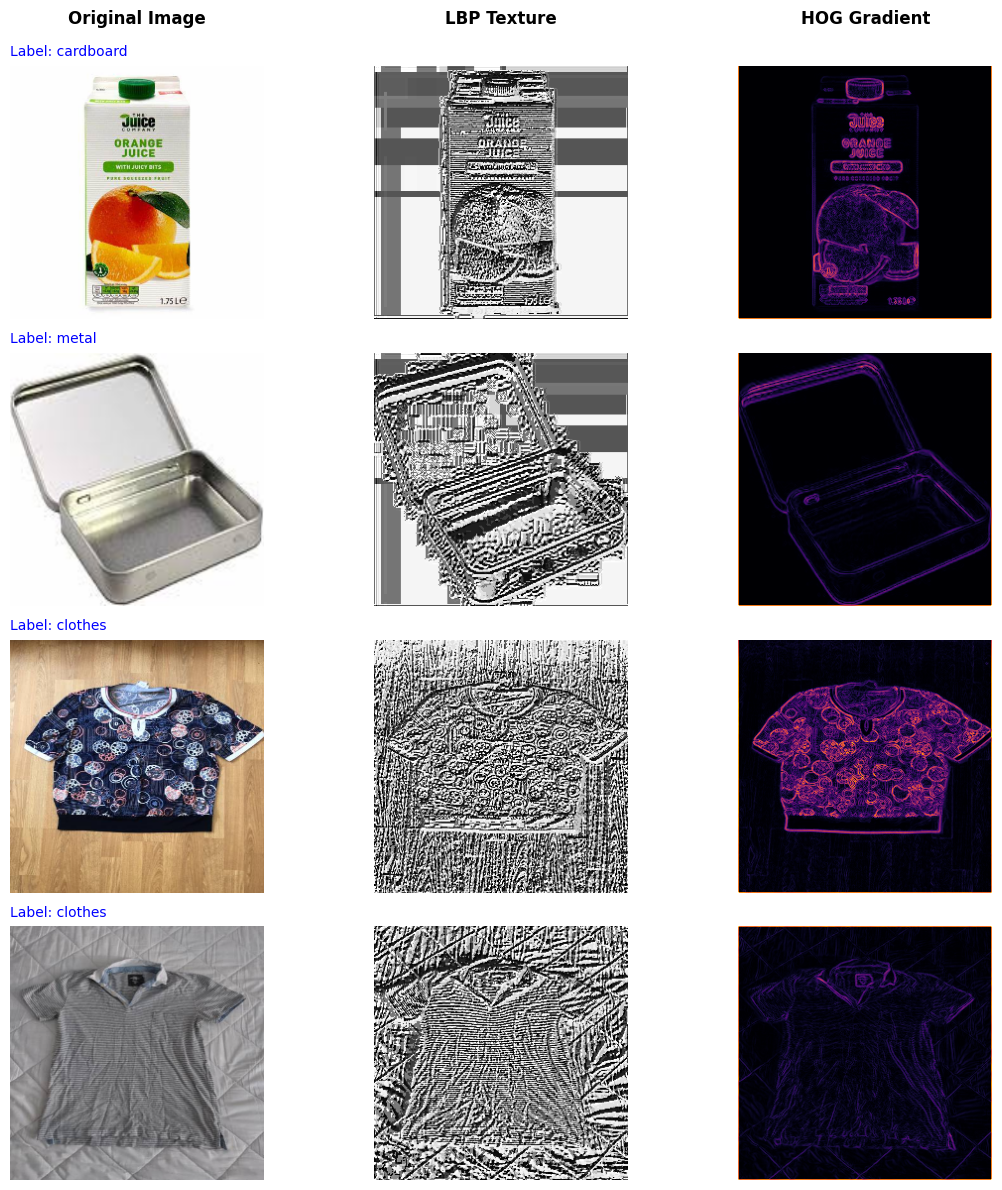


 > [Success] All images saved individually to folder: /kaggle/working/extracted_samples
 > You can find them in the 'Output' tab under '/kaggle/working/extracted_samples'
 > [Tip] A zip file 'samples_archive.zip' has also been created for easy download.


In [1]:
import os
import cv2
import time
import glob
import gc
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import cupy as cp
import cudf
import matplotlib.pyplot as plt

# Scikit-learn (CPU Helper)
# Used for data splitting and calculation of evaluation metrics.
# 用於數據集的分割以及最終評估指標（如 Accuracy, Precision, Recall）的計算。
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# PyTorch Data Utilities
# Used to build high-performance, parallel data loading pipelines.
# 用於構建高效、並行的數據加載管道，支持 pinned memory 以加速 CPU-GPU 傳輸。
from torch.utils.data import Dataset, DataLoader

# cuML libraries (RAPIDS - GPU Accelerated ML)
# 經典機器學習算法利用GPU 加速 (SVM, RandomForest, PCA)。
from cuml.svm import SVC
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.preprocessing import StandardScaler
from cuml.decomposition import PCA as GPU_PCA

# Suppress non-critical warnings from cuML/PyTorch
# 屏蔽非關鍵的用戶警告，保持控制台輸出整潔。
warnings.filterwarnings("ignore", category=UserWarning)

# =============================================================================
# 0. Configuration & Environment Setup (配置與環境設置)
# =============================================================================

# Cache directory for extracted features.
# 定義緩存目錄：用於存儲提取後的特徵 (numpy arrays)。
# Logic: Clean rebuild ensures no stale data interferes with the current run.
# 邏輯：如果目錄已存在則刪除重建，確保無殘留數據干擾。
CACHE_DIR = "./temp_features_cache"
if os.path.exists(CACHE_DIR):
    shutil.rmtree(CACHE_DIR)
os.makedirs(CACHE_DIR)

# -----------------------------------------------------------------------------
# GPU Locking Strategy (GPU 鎖定策略)
# -----------------------------------------------------------------------------
# Explicitly lock the process to a specific GPU ID to avoid contention.
# 強制使用指定的 GPU ID，避免多卡環境下的資源競爭。
DEVICE_ID = 0
try:
    # Set device for CuPy (CUDA Python)
    # 為 CuPy 設置設備
    cp.cuda.Device(DEVICE_ID).use()
    
    # Set device for PyTorch
    # 為 PyTorch 設置設備
    torch.cuda.set_device(DEVICE_ID)
    
    props = cp.cuda.runtime.getDeviceProperties(DEVICE_ID)
    print(f" > [System] Locked to GPU Device {DEVICE_ID}: {props['name'].decode('utf-8')}")
    print(f" > [System] Total VRAM: {props['totalGlobalMem'] / 1024**3:.2f} GB")
except Exception as e:
    print(f" > [Warning] Could not lock GPU: {e}")

def setup_seed(seed=42):
    """
    [Optimization] Global Random Seed Lock
    [優化] 全局隨機種子鎖定
    
    Goal (目的):
    Ensure deterministic behavior across CPU (Numpy), GPU (Cuda), and ML libraries.
    確保 CPU、GPU 和機器學習庫的隨機行為一致。
    
    Significance (意義):
    Crucial for reproducibility. Eliminates randomness as a variable in model performance.
    這對於復現實驗結果至關重要，消除了隨機性對模型性能評估的影響。
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Set CuDNN to deterministic mode (sacrifice slight speed for reproducibility)
    # 設置 CuDNN 為確定性模式，犧牲微小的性能換取結果的可復現性
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Lock CuPy random generator
    # 鎖定 CuPy 的隨機生成器
    cp.random.seed(seed)
    print(f" > [System] Random Seed Locked to {seed}")

def clean_memory():
    """
    [Utility] Deep Memory Clean
    [工具] 深度顯存與內存清理
    
    Goal (目的):
    Release resources before/after critical stages to prevent Out-Of-Memory (OOM).
    在訓練或特徵提取的關鍵階段前後釋放資源，防止顯存溢出。
    
    Mechanism (機制):
    Triggers Python Garbage Collection and explicitly empties PyTorch/CuPy memory pools.
    觸發 Python 垃圾回收，並顯式清空 PyTorch 和 CuPy 的內存池。
    """
    gc.collect()
    if torch.cuda.is_available():
        try: torch.cuda.empty_cache()
        except: pass
    try:
        # Free CuPy memory blocks
        # 釋放 CuPy 佔用的顯存塊
        mempool = cp.get_default_memory_pool()
        pinned_mempool = cp.get_default_pinned_memory_pool()
        mempool.free_all_blocks()
        pinned_mempool.free_all_blocks()
    except: pass

# =============================================================================
# 1. Feature Extraction Modules (特徵提取模塊)
# =============================================================================

class LBP_GPU(nn.Module):
    """
    [Feature Extractor] GPU-Accelerated Local Binary Patterns (LBP)
    [特徵提取器] GPU 加速局部二值模式
    
    Principle (原理):
    Encodes texture by comparing a center pixel with its neighbors.
    通過比較中心像素與圓形鄰域像素的灰度值來編碼紋理信息。
    
    Implementation (實現):
    Uses PyTorch tensor operations and `grid_sample` to avoid loops, purely on GPU.
    利用 PyTorch 的矩陣運算和採樣函數，完全在 GPU 上並行化執行，避免了低效的 Python 循環。
    """
    def __init__(self, radius=1):
        super().__init__()
        self.points = 8  # Number of sampling points (採樣點數量)
        self.radius = radius
        
        # Pre-compute circular sampling coordinates offsets
        # 預計算圓周上的採樣點相對坐標 (使用三角函數)
        angles = torch.linspace(0, 2*np.pi, self.points+1)[:-1].double()
        self.register_buffer('offsets_x', (radius * torch.cos(angles)).float())
        self.register_buffer('offsets_y', (-radius * torch.sin(angles)).float())
        
        # Weights for binary encoding (Powers of 2: 1, 2, 4, 8...)
        # 用於二進制編碼的權重：將 8 個比較結果轉換為一個 0-255 的整數值
        weights = 2 ** torch.arange(self.points)
        self.register_buffer('weights', weights.float().view(1, self.points, 1, 1))
        
        # Grid cache to avoid re-computation during forward pass
        # 網格緩存，用於避免重複計算坐標網格
        self.grid_cache = None
        self.cached_shape = (0, 0)

    def forward(self, img, visualize=False):
        # [Input Requirement] LBP requires Grayscale input (N, 1, H, W)
        # [輸入要求] LBP 算法必須使用灰度圖像。如果輸入是 3 維，增加通道維度。
        if img.dim() == 4 and img.shape[1] == 3:
            # Standard Grayscale weights: 0.299R + 0.587G + 0.114B
            weights = torch.tensor([0.299, 0.587, 0.114], device=img.device).view(1, 3, 1, 1)
            img = (img * weights).sum(dim=1, keepdim=True)
        
        if img.dim() == 3: img = img.unsqueeze(1)
        N, C, H, W = img.shape

        # 1. Construct Sampling Grid (構建採樣網格)
        # Only recompute if image size changes.
        # 僅當圖像尺寸發生變化時才重新計算，節省計算資源。
        if self.grid_cache is None or self.cached_shape != (H, W):
            y_range = torch.arange(H, device=img.device, dtype=torch.float32)
            x_range = torch.arange(W, device=img.device, dtype=torch.float32)
            grid_y, grid_x = torch.meshgrid(y_range, x_range, indexing='ij')
            self.cached_shape = (H, W)
            self.grid_cache = (grid_y, grid_x)
        else:
            grid_y, grid_x = self.grid_cache

        # 2. Sample Neighbors (採樣周圍 8 個鄰居點)
        neighbors = []
        for i in range(self.points):
            # Calculate absolute coordinates of sampling point
            # 計算採樣點的絕對坐標
            sample_x = grid_x + self.offsets_x[i]
            sample_y = grid_y + self.offsets_y[i]
            
            # Normalize coordinates to [-1, 1] for grid_sample
            # 歸一化坐標到 [-1, 1] 區間，這是 grid_sample 函數要求的格式
            norm_x = 2.0 * (sample_x / (W - 1)) - 1.0
            norm_y = 2.0 * (sample_y / (H - 1)) - 1.0
            grid = torch.stack((norm_x, norm_y), dim=-1).expand(N, -1, -1, -1)
            
            # Bilinear Interpolation Sampling
            # 雙線性插值採樣：允許採樣點落在非整數坐標上，提高旋轉不變性精度
            sampled = F.grid_sample(img, grid, mode='bicubic', padding_mode='reflection', align_corners=True)
            neighbors.append(sampled)
        
        # 3. Threshold & Encode (閾值比較與編碼)
        # Compare neighbors with center pixel to generate binary code.
        # 將鄰居像素與中心像素進行比較，生成二進制碼 (大於中心為1，否則為0)。
        neighbors = torch.cat(neighbors, dim=1)
        center = img.expand(-1, self.points, -1, -1)
        binary = (neighbors >= center).float()
        
        # Weighted sum to get final LBP integer code
        # 加權求和得到最終的 LBP 值
        lbp_code = (binary * self.weights).sum(dim=1, keepdim=True)

        # [Modification] Return Map for Visualization
        # [修改] 如果是用於可視化，直接返回 LBP 紋理圖 (feature map)
        if visualize:
            return lbp_code # (N, 1, H, W)

        
        return lbp_code

class HOGLayer(nn.Module):
    """
    [Feature Extractor] GPU-Accelerated HOG (Histogram of Oriented Gradients)
    [特徵提取器] HOG 梯度方向直方圖實現
    
    Configuration (配置):
    - nbins: 12 (Histogram bins / 方向桶數)
    - pool: 16 (Cell pooling size / Cell 池化大小)
    - range: 0 ~ 360 degrees (Full orientation / 全方向梯度)
    
    Methodology (方法論):
    Strict adherence to classic CV pipeline with Color Optimization.
    嚴格按照經典計算機視覺流程實現，並結合色彩優化策略。
    """
    def __init__(self, nbins=12, pool=16, max_angle=2*np.pi):
        super(HOGLayer, self).__init__()
        self.nbins = nbins        # 12 direction bins
        self.pool = pool          # 16*16 pixel cell
        self.max_angle = max_angle # 2*PI (360 degrees)

        # Gradient Kernels (梯度卷積核)
        # Uses standard [-1, 0, 1] central difference kernel.
        # No Gaussian smoothing, preserving sharp edges for texture extraction.
        # HOG 原論文推薦使用簡單的 [-1, 0, 1] 中心差分核，不進行高斯平滑以保留邊緣信息。
        kernel_x = torch.tensor([[-1., 0., 1.]], dtype=torch.float32).view(1, 1, 1, 3)
        kernel_y = torch.tensor([[-1.], [0.], [1.]], dtype=torch.float32).view(1, 1, 3, 1)

        self.register_buffer("kernel_x", kernel_x)
        self.register_buffer("kernel_y", kernel_y)

    def forward(self, x, visualize=False):
        """
        Input x: (N, 3, H, W) RGB Image
        """
        # ==================================================================
        # [1] Gamma Calibration (Gamma 校準)
        # ==================================================================
        # Square root compression (Gamma = 0.5).
        # Compresses highlights and boosts shadows to mitigate lighting variations.
        # 對輸入圖像進行平方根運算 (Gamma=0.5)。作用是壓縮高光部分，提升暗部細節，減少光照變化的影響。
        x = torch.sqrt(x + 1e-6)

        # ==================================================================
        # [2] Dimension Handling (維度處理)
        # ==================================================================
        # Ensure 4D tensor (Batch, Channel, Height, Width).
        # 確保輸入是 4D 張量以便進行卷積運算。
        if x.dim() == 3: 
            x = x.unsqueeze(0)

        # ==================================================================
        # [3] Gradient Computation (計算梯度)
        # ==================================================================
        C = x.shape[1] # Channels (usually 3)

        # Repeat kernels for each channel to compute gradients independently.
        # 將卷積核在通道維度複製 C 次，使 R, G, B 三個通道分別獨立計算梯度。
        weight_x = self.kernel_x.repeat(C, 1, 1, 1)
        weight_y = self.kernel_y.repeat(C, 1, 1, 1)
        
        # 1. Compute gradients (padding ensures output size match).
        # 計算水平和垂直方向的梯度 (padding 確保輸出尺寸不變)。
        g_x = F.conv2d(x, weight_x, padding=(0, 1), groups=C)
        g_y = F.conv2d(x, weight_y, padding=(1, 0), groups=C)

        # 2. Compute Magnitude & Angle (計算幅值與角度)
        # Magnitude: Euclidean distance. Angle: Arctan.
        # 幅值使用歐幾里得距離公式，角度使用反正切函數。
        mag = torch.sqrt(g_x**2 + g_y**2 + 1e-6)
        ang = torch.atan2(g_y, g_x) # Range: (-PI, PI)

        # 3. [Color Optimization] Max-Gradient Selection
        # [色彩優化] 跨通道最大值選取
        # Instead of converting to grayscale first, select the channel with the max gradient magnitude.
        # 不預先轉為灰度圖，而是對每個像素點，選取 RGB 三個通道中梯度幅值最大的那個通道的數據。
        if x.shape[1] > 1:
            mag, idx = torch.max(mag, dim=1, keepdim=True)
            # Use gather to select the angle corresponding to the max magnitude
            # 使用 gather 根據索引提取對應最大幅值的角度
            ang = torch.gather(ang, 1, idx)

        # [Modification] Return Gradient Magnitude for Visualization
        # [修改] 如果是用於可視化，返回梯度幅值圖 (這展示了 HOG 關注的邊緣)
        if visualize:
            return mag # (N, 1, H, W)
        
        # Result: mag/ang shape is (N, 1, H, W) -> Reduced to single channel.

        # ==================================================================
        # [4] Angle Normalization (角度歸一化)
        # ==================================================================
        # Convert negative angles to positive [0, 2*PI).
        # 將負角度轉換為正值，使其範圍適配 0-360 度的直方圖。
        if self.max_angle == 2*np.pi:
            ang = torch.where(ang < 0, ang + self.max_angle, ang)

        # ==================================================================
        # [5] Bin Allocation - Soft Voting (梯度方向分配 - 軟投票)
        # ==================================================================
        # Linear interpolation to split magnitude between two adjacent bins.
        # Reduces histogram aliasing caused by small angle variations.
        # 軟投票機制：使用線性插值將一個像素的梯度幅值分配到相鄰的兩個方向桶中，減少混疊效應。
        bin_width = self.max_angle / self.nbins
        bin_float = ang / bin_width
        
        # Calculate left and right bin indices (Cyclic for 360 deg)
        # 計算左桶和右桶索引 (處理 360 度循環邊界)
        bin_left = torch.floor(bin_float).long() % self.nbins
        bin_right = (bin_left + 1) % self.nbins
        
        # Calculate weights (closer bin gets more weight)
        # 計算分配權重 (距離越近權重越大)
        weight_right = bin_float - torch.floor(bin_float)
        weight_left = 1.0 - weight_right

        # ==================================================================
        # [6] Accumulation (加權累加到直方圖)
        # ==================================================================
        N, _, H, W = mag.shape
        hog_map = torch.zeros((N, self.nbins, H, W), device=x.device, dtype=x.dtype)
        
        # Efficiently scatter magnitudes into bins in parallel
        # 使用 scatter_add_ 高效並行地將梯度幅值按計算好的權重填入對應的 bin
        hog_map.scatter_add_(1, bin_left, mag * weight_left)
        hog_map.scatter_add_(1, bin_right, mag * weight_right)

        # ==================================================================
        # [7] Cell Pooling (Cell 池化)
        # ==================================================================
        # Sum gradients within each Cell.
        # Implemented via AvgPool * Area (leveraging optimized PyTorch ops).
        # 對每個 Cell 區域內的梯度直方圖進行匯總。使用平均池化後乘以面積等效於求和。
        hog_cell = F.avg_pool2d(hog_map, kernel_size=self.pool, stride=self.pool) * (self.pool**2)

        # ==================================================================
        # [8] Block Construction (構建塊描述子)
        # ==================================================================
        # 2x2 Sliding Block with 50% overlap.
        # 採用 2x2 滑動塊的方式組織相鄰的 Cell。每個 Block 包含 4 個 Cell，步長為 1 個 Cell。
        c1 = hog_cell[:, :, 0:-1, 0:-1]
        c2 = hog_cell[:, :, 0:-1, 1:]
        c3 = hog_cell[:, :, 1:, 0:-1]
        c4 = hog_cell[:, :, 1:, 1:]
        
        # Concatenate 4 cells into one block vector
        # 將 4 個 Cell 的直方圖拼接成一個長向量
        block = torch.cat((c1, c2, c3, c4), dim=1)

        # ==================================================================
        # [9] Block Normalization - L2-Hys (塊歸一化)
        # ==================================================================
        # L2-Hysteresis: More robust than simple L2.
        # 採用 L2-Hysteresis 歸一化策略，比普通的 L2 歸一化更穩健。
        
        # 1. First L2 Normalization (第一次 L2 歸一化)
        norm = torch.sqrt(torch.sum(block**2, dim=1, keepdim=True) + 1e-6)
        block_norm = block / norm
        
        # 2. Clamping (截斷)
        # Limit max contribution of any single bin (e.g., 0.2) to suppress strong shadows.
        # 限制任何單一方向梯度的最大貢獻值 (例如 0.2)，抑制強光源或陰影邊緣產生的過大梯度。
        block_norm = torch.clamp(block_norm, max=0.2)
        
        # 3. Second L2 Normalization (第二次 L2 歸一化)
        # Re-normalize after clamping.
        # 對截斷後的向量再次歸一化。
        norm = torch.sqrt(torch.sum(block_norm**2, dim=1, keepdim=True) + 1e-6)
        block_norm = block_norm / norm

        return block_norm

# =============================================================================
# 2. Data Extraction Pipeline (數據提取管道)
# =============================================================================

class GarbageDataset(Dataset):
    """
    [Dataset Loader] Custom Dataset
    [數據加載器] 自定義數據集類
    
    Key Settings (關鍵設定):
    1. RGB Output: Reads and returns RGB images (crucial for Color-HOG).
    2. Normalize: Scales pixel values to [0, 1].
    3. Layout: Returns (C, H, W) format, matching PyTorch convention.
    """
    def __init__(self, file_paths, labels, img_size=256):
        self.file_paths = file_paths
        self.labels = labels
        self.img_size = img_size 
        
    def __len__(self):
        return len(self.file_paths)
        
    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label = self.labels[idx]
        img = cv2.imread(path) # Defaults to BGR
        
        if img is None:
            # Fault Tolerance: Return black image if file is corrupt
            # 容錯處理：如果圖片損壞，返回全黑圖像
            img = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)
        else:
            # Convert BGR to RGB
            # 轉換為 RGB 格式 (OpenCV 默認為 BGR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            img = cv2.resize(img, (self.img_size, self.img_size))
        
        # Convert to Float32 and Normalize
        # 轉換為 Float32 並歸一化到 0-1
        img = img.astype(np.float32) / 255.0
        # Transpose dimensions: (H, W, C) -> (C, H, W)
        # 轉置維度以適配 PyTorch 格式
        img = np.transpose(img, (2, 0, 1))
        
        return torch.from_numpy(img), label

def process_and_save_features():
    """
    [Main ETL Function] Feature Extraction & Caching
    [主提取函數] 特徵提取與緩存
    
    Workflow (流程):
    1. Load Dataset (Keep RGB).
    2. Convert RGB -> Gray dynamically on GPU (For LBP).
    3. Feed RGB to HOG (HOG handles its own color processing).
    4. Transfer features GPU -> CPU -> Disk Cache.
    """
    path = "/kaggle/input/garbage-classification-v2/garbage-dataset"
    
    if not os.path.exists(path):
        print("Error: Dataset path not found.")
        return 0, []
    
    categ = ["metal", "battery", "biological", "cardboard", "trash", "clothes", "paper", "glass", "shoes", "plastic"]
    IMG_SIZE = 256
    BATCH_SIZE = 1024  # Batch size (adjust based on VRAM)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize Feature Extractors
    # 初始化特徵提取模型
    lbp_extractor_r1 = LBP_GPU(radius=1).to(device)
    lbp_extractor_r2 = LBP_GPU(radius=2).to(device)
    lbp_extractor_r3 = LBP_GPU(radius=3).to(device)
    # [User Requirement] HOG Config: 12 bins, 16x16 pool, 0-360 degrees
    hog_extractor = HOGLayer(nbins=12, pool=16, max_angle=2*np.pi).to(device)
    
    print(f" > Feature Extractors initialized")
    
    # Collect all image paths and labels
    # 收集所有圖像文件的路徑和標籤
    all_img_paths = []
    all_labels = []
    for i, c_name in enumerate(categ):
        folder_path = os.path.join(path, c_name)
        files = glob.glob(os.path.join(folder_path, "*"))
        for f in files:
            all_img_paths.append(f)
            all_labels.append(i)
            
    if len(all_img_paths) == 0: return 0, []
        
    dataset = GarbageDataset(all_img_paths, all_labels, img_size=IMG_SIZE)
    
    # Setup PyTorch DataLoader
    # pin_memory=True accelerates CPU->GPU transfer
    num_workers = os.cpu_count()
    loader = DataLoader(
        dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=num_workers, 
        pin_memory=True,
        prefetch_factor=2 if num_workers > 0 else None,
        persistent_workers=True if num_workers > 0 else False
    )
    
    print(f" > Total images: {len(all_img_paths)}. Starting extraction...")
    
    # Temporary GPU lists for caching features (Reduces PCI-E bandwidth pressure)
    # 創建 GPU 列表緩存特徵 (避免每一步都傳回 CPU，減少 PCI-E 帶寬壓力)
    lbp_gpu_list = []
    hog_gpu_list = []
    labels_list = []
    
    # ==================================================================
    # [LBP Grayscale Conversion Formula]
    # ==================================================================
    # Standard ITU-R BT.601 brightness formula: Y = 0.299R + 0.587G + 0.114B
    # 標準亮度轉換公式，符合人眼感知。
    gray_weights = torch.tensor([0.299, 0.587, 0.114], device=device).view(1, 3, 1, 1)

    def compute_vectorized_hist(lbp_out, B, device):
        """
        Helper: Compute and Normalize LBP Histogram via Vectorization.
        輔助函數：使用 bincount 進行向量化統計 LBP 直方圖，避免循環。
        """
        lbp_flat = lbp_out.view(B, -1).long()
        # Offset trick to compute histograms for the entire batch in parallel
        # 通過偏移量技巧，並行計算 Batch 中所有圖像的直方圖
        offset = torch.arange(B, device=device).unsqueeze(1) * 256
        lbp_offset = lbp_flat + offset
        hist = torch.bincount(lbp_offset.view(-1), minlength=B*256)
        hist = hist.view(B, 256).float()
        # Normalize histogram (Sum = 1)
        # 歸一化直方圖 (使其和為 1)
        return hist / (hist.sum(dim=1, keepdim=True) + 1e-6)

    # Warmup GPU
    if torch.cuda.is_available(): torch.cuda.synchronize()
    t_start = time.time()
    
    for i, (batch_imgs, batch_labels) in enumerate(loader):
        # batch_imgs is RGB (B, 3, H, W)
        batch_tensor = batch_imgs.to(device, non_blocking=True)
        
        with torch.no_grad():
            B = batch_tensor.shape[0]

            # --- 1. LBP (Requires Grayscale) ---
            # Dynamic conversion: RGB -> Gray
            # 動態轉換 RGB -> Gray
            #batch_gray = (batch_tensor * gray_weights).sum(dim=1, keepdim=True)
            
            # Extract features at 3 radii scales & compute histograms
            # 提取三個不同半徑的 LBP 特徵並計算直方圖
            out_r1 = lbp_extractor_r1(batch_tensor)
            hist_r1 = compute_vectorized_hist(out_r1, B, device)
            out_r2 = lbp_extractor_r2(batch_tensor)
            hist_r2 = compute_vectorized_hist(out_r2, B, device) 
            out_r3 = lbp_extractor_r3(batch_tensor)
            hist_r3 = compute_vectorized_hist(out_r3, B, device) 
            
            # Concatenate Multi-scale Features
            # 拼接多尺度特徵
            lbp_combined = torch.cat([hist_r1, hist_r2,hist_r3], dim=1)
            lbp_gpu_list.append(lbp_combined)
            
            # --- 2. HOG (Keeps RGB) ---
            # Color-HOG uses raw RGB tensor; Gamma & Gradients handled internally.
            # Color-HOG 使用原始 RGB 張量計算，內部會進行 Gamma 校準和色彩梯度計算。
            hog_out = hog_extractor(batch_tensor)
            hog_gpu_list.append(hog_out.view(B, -1))
            
        labels_list.append(batch_labels)
        print(f"Batch {i+1}/{len(loader)}...", end='\r')

    if torch.cuda.is_available(): torch.cuda.synchronize()
    t_extract = time.time() - t_start
    print(f"\nExtraction complete ({t_extract:.2f}s). Transferring to CPU...")
    
    # Transfer back to CPU memory
    # 將所有數據一次性轉移回 CPU 內存
    X_lbp = torch.cat(lbp_gpu_list, dim=0).cpu().numpy().astype(np.float32)
    X_hog = torch.cat(hog_gpu_list, dim=0).cpu().numpy().astype(np.float32)
    Y = np.concatenate([l.numpy() for l in labels_list]).astype(np.int32)
    
    # Cleanup GPU variables
    # 資源清理：刪除 GPU 緩存變量並調用垃圾回收
    del lbp_gpu_list, hog_gpu_list, labels_list, loader, dataset
    clean_memory()
    
    # Save to Disk Cache
    # 保存到硬盤緩存
    np.save(os.path.join(CACHE_DIR, 'X_lbp.npy'), X_lbp)
    np.save(os.path.join(CACHE_DIR, 'X_hog.npy'), X_hog)
    np.save(os.path.join(CACHE_DIR, 'Y.npy'), Y)
    
    print(f"Data Saved: LBP Shape {X_lbp.shape}, HOG Shape {X_hog.shape}")
    
    # Clear large arrays from RAM
    # 清理內存中的大數組
    del X_lbp, X_hog, Y
    clean_memory()
    
    return t_extract, categ

# =============================================================================
# 3. Data Optimization & Sampling (數據優化與採樣)
# =============================================================================

def manual_oversampling_gpu(X, y):
    """ 
    [Strategy] GPU Random Oversampling
    [策略] GPU 隨機過採樣
    
    Function (功能): 
    Balances the dataset directly in VRAM to fix class imbalance.
    在 GPU 顯存中直接進行隨機過採樣，解決類別不平衡問題。
    
    Advantage (優勢):
    Significantly faster than CPU methods; avoids data transfer overhead.
    相比 CPU 實現，GPU 版本極大減少了數據搬運開銷。
    
    Details (細節):
    1. Seed Locking: Uses `cp.random.seed` for consistency.
    2. Memory Layout: Returns `ascontiguousarray` for faster compute.
    """
    X = cp.asarray(X)
    y = cp.asarray(y)

    # Get unique classes and counts
    # 獲取唯一類別和每個類別的樣本數
    unique_classes, counts = cp.unique(y, return_counts=True)
    max_samples = int(cp.max(counts))
    
    all_X = []
    all_y = []
    
    # Reproducibility Check
    # 確保採樣過程可復現
    cp.random.seed(42)

    for cls in unique_classes:
        cls_indices = cp.where(y == cls)[0]
        n_current = len(cls_indices)
        
        # Add original data
        # 添加該類別的原始數據
        all_X.append(X[cls_indices])
        all_y.append(y[cls_indices])
        
        # If samples < max_samples, sample with replacement to fill the gap
        # 如果樣本數不足最大類別，進行隨機重複採樣補齊數量
        if n_current < max_samples:
            n_needed = max_samples - n_current
            # Random choice with replacement
            # 有放回地隨機選擇索引
            random_indices = cp.random.choice(cls_indices, n_needed, replace=True)
            all_X.append(X[random_indices])
            all_y.append(y[random_indices])
            
    X_out = cp.vstack(all_X)
    y_out = cp.hstack(all_y)
    
    # Shuffle to prevent order dependency
    # 隨機打亂所有樣本，防止模型依賴於數據順序
    perm = cp.random.permutation(len(X_out))
    
    return cp.ascontiguousarray(X_out[perm]), cp.ascontiguousarray(y_out[perm])

# =============================================================================
# 4. Training & Evaluation Pipeline (訓練與評估管道)
# =============================================================================

def train_evaluate_pipeline(feature_type, model_type, class_names):
    clean_memory()
    print(f"\n>>> Processing: {model_type} + {feature_type.upper()}")
    
    # [Logic Update] Feature Fusion Handling
    # [邏輯更新] 處理特徵融合
    if feature_type == 'combined':
        print(" > [Data Load] Loading LBP and HOG for Fusion...")
        path_lbp = os.path.join(CACHE_DIR, 'X_lbp.npy')
        path_hog = os.path.join(CACHE_DIR, 'X_hog.npy')
        
        # Use mmap to save RAM, then stack on CPU
        # 使用 mmap 加載以節省 RAM，然後在 CPU 進行拼接
        X_lbp = np.load(path_lbp, mmap_mode='r')
        X_hog = np.load(path_hog, mmap_mode='r')
        
        # Feature Concatenation: Triggers actual read
        # 拼接特徵：這會觸發實際的內存讀取. Shape: (N, D_lbp + D_hog)
        X_cpu = np.hstack((X_lbp, X_hog))
        
        del X_lbp, X_hog # Release handles
    else:
        # Single Feature Load
        # 單一特徵加載
        feature_path = os.path.join(CACHE_DIR, f'X_{feature_type}.npy')
        X_cpu = np.load(feature_path, mmap_mode='r') # Keep mmap until split

    label_path = os.path.join(CACHE_DIR, 'Y.npy')
    y_cpu = np.load(label_path) 
    
    # =========================================================
    # [1] Deterministic Split (確定性分割)
    # =========================================================
    X_train_cpu, X_test_cpu, y_train_cpu, y_test_cpu = train_test_split(
        X_cpu, y_cpu, test_size=0.2, random_state=42, stratify=y_cpu
    )
    
    y_true_final = y_test_cpu 
    
    # Free large CPU array if it was 'combined'
    # 如果是 combined，現在釋放 X_cpu 大數組
    if feature_type == 'combined': del X_cpu
    clean_memory()

    # =========================================================
    # [2] Data Transfer to GPU (數據傳輸至 GPU)
    # =========================================================
    print(" > [VRAM Strategy] Loading data to GPU...")
    try:
        X_train_gpu = cp.asarray(X_train_cpu)
        y_train_gpu = cp.asarray(y_train_cpu).astype(np.int32)
        X_test_gpu = cp.asarray(X_test_cpu)
        
        del X_train_cpu, X_test_cpu, y_train_cpu, y_test_cpu
        clean_memory()
    except MemoryError:
        print(" !!! Error: GPU OOM. Try reducing batch size or using single features.")
        return {"Model": f"{model_type}+{feature_type}", "Accuracy": 0.0}

    # =========================================================
    # [3] Preprocessing Pipeline (預處理管道)
    # =========================================================
    
    # 3.1 Oversampling (Train Only) / 過採樣 (僅訓練集)
    print(" > [Pipeline] GPU Oversampling (Train Only)...")
    X_train_gpu, y_train_gpu = manual_oversampling_gpu(X_train_gpu, y_train_gpu)
    
    # 3.2 Scaling / 標準化
    print(" > [Pipeline] Standard Scaling...")
    scaler = StandardScaler()
    X_train_gpu = scaler.fit_transform(X_train_gpu)
    X_test_gpu = scaler.transform(X_test_gpu)
    
    # 3.3 PCA Strategy (Modified) / PCA 降維策略
    # PCA is mandatory for SVM with High-Dim features (HOG/Combined) to control complexity.
    # RF is robust to high dimensions, so PCA is skipped unless OOM.
    # 對於 HOG 或 Combined 特徵，如果使用 SVM，必須進行 PCA 以控制維度。
    use_pca = (model_type == 'SVM' and (feature_type == 'hog' or feature_type == 'combined'))
    
    if use_pca:
        n_features = X_train_gpu.shape[1]
        # Limit components to 4096 or n_features
        # 限制在 4096
        n_components = min(4096, n_features) 
        print(f" > [Pipeline] GPU PCA ({n_features} -> {n_components})...")
        
        pca = GPU_PCA(n_components=n_components, svd_solver='full')
        
        X_train_gpu = X_train_gpu.astype(cp.float32)
        X_test_gpu = X_test_gpu.astype(cp.float32)
        
        X_train_gpu = pca.fit_transform(X_train_gpu)
        X_test_gpu = pca.transform(X_test_gpu)

        del pca
        clean_memory()
    else:
        print(f" > [Pipeline] Skipping PCA for {model_type} (Using Raw Features)")
    
    X_train_final = X_train_gpu
    y_train_final = y_train_gpu
    X_test_final = X_test_gpu
    
    train_data_shape = X_train_final.shape

    # =========================================================
    # [4] Training (模型訓練)
    # =========================================================

    print(f" > Training model... (Data Shape: {train_data_shape})")
    t_start = time.time()
    
    try:
        if model_type == 'SVM':
            model = SVC(C=10.0, 
                        kernel='rbf', 
                        gamma='scale', 
                        max_iter=20000, 
                        tol=1e-3, 
                        cache_size=4000)
            model.fit(X_train_final, y_train_final)
            
        elif model_type == 'RF':
            # RF parameters tuned for Combined features
            # RF 參數調整以適應高維融合特徵
            model = cuRF(
                n_estimators=500, 
                max_depth=32,       
                n_bins=128,         
                n_streams=4,
                random_state=42
            )
            model.fit(X_train_final, y_train_final)
            
    except MemoryError:
        print(" !!! OOM during Training.")
        return {"Model": f"{model_type}+{feature_type}", "Accuracy": 0.0}

    t_train = time.time() - t_start
    
    # =========================================================
    # [5] Inference & Evaluation (推理與評估)
    # =========================================================
    print(" > Inferencing...")
    t_infer_start = time.time()
    preds = model.predict(X_test_final)
    t_infer = time.time() - t_infer_start
    
    if hasattr(preds, 'to_numpy'): y_pred = preds.to_numpy()
    elif hasattr(preds, 'get'): y_pred = preds.get()
    else: y_pred = np.array(preds)
    y_pred = y_pred.astype(int)
    
    acc = classification_report(y_true_final, y_pred, target_names=class_names, output_dict=True)['accuracy']
    print(f" > Accuracy: {acc:.8f}")
    
    # Print detailed classification report
    # 顯示詳細的分類報告表格
    print(classification_report(y_true_final, y_pred, target_names=class_names, zero_division=0))
    
    del model, X_train_final, y_train_final, X_test_final
    clean_memory()
    
    return {
        "Model": f"{model_type} + {feature_type.upper()}",
        "Accuracy": acc,
        "Train Data Shape": str(train_data_shape),
        "Train Time(s)": t_train,
        "Infer Time(s)": t_infer,
        "Total Time(s)": t_train + t_infer
    }

# =============================================================================
# 5. Random Verification (隨機驗證)
# =============================================================================

def run_random_verification(df_results, class_names, sample_count=20):
    """
    [Verification] Random Spot Check with Best Model
    [驗證] 最佳模型隨機抽樣檢查
    """
    print("\n" + "="*60)
    print(f" >>> Starting Random Verification (Sample Size: {sample_count})")
    print("="*60)

    # 1. Get Best Model Info (獲取最佳模型信息)
    best_row = df_results.sort_values(by="Accuracy", ascending=False).iloc[0]
    best_model_name = best_row["Model"]
    print(f" > Best Performing Model: [{best_model_name}]")
    print(f" > Historical Accuracy:    {best_row['Accuracy']:.4f}")

    # Parse Model and Feature Types
    # 解析模型和特徵類型 (Combined 字符串可能不包含 LBP/HOG 關鍵字)
    if 'Combined' in best_model_name:
        feature_type = 'combined'
    elif 'HOG' in best_model_name:
        feature_type = 'hog'
    else:
        feature_type = 'lbp'
        
    model_type = 'SVM' if 'SVM' in best_model_name else 'RF'

    # 2. Reload Data (重新加載數據)
    clean_memory()
    label_path = os.path.join(CACHE_DIR, 'Y.npy')
    y_all = np.load(label_path)
    
    # [Data Load Update] Handle Fusion
    # [數據加載] 處理 Combined 情況
    if feature_type == 'combined':
        print(" > [Verification] Loading & Fusing LBP + HOG features...")
        path_lbp = os.path.join(CACHE_DIR, 'X_lbp.npy')
        path_hog = os.path.join(CACHE_DIR, 'X_hog.npy')
        X_lbp = np.load(path_lbp, mmap_mode='r')
        X_hog = np.load(path_hog, mmap_mode='r')
        X_all = np.hstack((X_lbp, X_hog))
        del X_lbp, X_hog
    else:
        feature_path = os.path.join(CACHE_DIR, f'X_{feature_type}.npy')
        X_all = np.load(feature_path, mmap_mode='r')

    # 3. Prepare Training Env (準備訓練環境)
    # Must use same random state (42) to replicate the original split.
    # 必須使用與訓練管道完全相同的 Split Random State (42) 以保證數據分佈一致。
    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
    )
    
    # Move to GPU
    # 轉移到 GPU
    X_train_gpu = cp.asarray(X_train)
    y_train_gpu = cp.asarray(y_train).astype(np.int32)
    
    # 3.1 Oversampling (過採樣)
    X_train_gpu, y_train_gpu = manual_oversampling_gpu(X_train_gpu, y_train_gpu)
    
    # 3.2 Scaling (標準化)
    scaler = StandardScaler()
    X_train_gpu = scaler.fit_transform(X_train_gpu)
    
    # 3.3 PCA Logic (PCA 邏輯)
    pca = None
    use_pca = (model_type == 'SVM' and (feature_type == 'hog' or feature_type == 'combined'))
    
    if use_pca:
        n_features = X_train_gpu.shape[1]
        n_components = min(4096, n_features)
        print(f" > [Verification] Applying PCA ({n_features} -> {n_components})...")
        
        pca = GPU_PCA(n_components=n_components, svd_solver='full')
        X_train_gpu = X_train_gpu.astype(cp.float32)
        X_train_gpu = pca.fit_transform(X_train_gpu)

    # 4. Retrain Model (重新訓練模型)
    print(f" > Retraining {best_model_name} for spot check...")
    model = None
    if model_type == 'SVM':
        # Same params as pipeline
        model = SVC(C=10.0, 
                    kernel='rbf', 
                    gamma='scale', 
                    max_iter=20000, 
                    tol=1e-3, 
                    cache_size=4000)
    else:
        # Same params as pipeline
        model = cuRF(n_estimators=500, max_depth=32, n_bins=128) 
    
    model.fit(X_train_gpu, y_train_gpu)

    # 5. Unweighted Random Sampling (無權重隨機抽樣)
    # Sample from X_test (Unseen Data).
    # 從保留的 X_test (CPU) 中抽取，模型未見過的數據。
    test_samples_count = len(y_test)
    real_sample_count = min(sample_count, test_samples_count)
    
    # Random Choice
    # 隨機選擇索引
    random_indices = np.random.choice(test_samples_count, real_sample_count, replace=False)
    
    X_sample_cpu = X_test[random_indices] 
    y_true_sample = y_test[random_indices]
    
    # 6. Preprocess Sampled Data (預處理抽樣數據)
    X_sample_gpu = cp.asarray(X_sample_cpu)
    
    # Apply fitted Scaler
    # 應用之前擬合的 Scaler
    X_sample_gpu = scaler.transform(X_sample_gpu)
    
    # Apply fitted PCA (if exists)
    # 應用之前擬合的 PCA (如果有)
    if pca is not None:
        X_sample_gpu = X_sample_gpu.astype(cp.float32)
        X_sample_gpu = pca.transform(X_sample_gpu)
        
    # 7. Predict (預測)
    preds = model.predict(X_sample_gpu)
    
    if hasattr(preds, 'to_numpy'): y_pred_sample = preds.to_numpy()
    elif hasattr(preds, 'get'): y_pred_sample = preds.get()
    else: y_pred_sample = np.array(preds)
    
    y_pred_sample = y_pred_sample.astype(int)

    # 8. Result Calculation & Display (計算與展示結果)
    correct_count = np.sum(y_true_sample == y_pred_sample)
    random_acc = correct_count / sample_count
    
    print("\n" + "-"*30)
    print(f" [Random Verification Result]")
    print("-" * 30)
    
    # Create Display Table
    # 創建展示表格
    results_display = []
    for i in range(sample_count):
        true_name = class_names[y_true_sample[i]]
        pred_name = class_names[y_pred_sample[i]]
        status = "✅" if true_name == pred_name else "❌"
        results_display.append({
            "Sample ID": i,
            "True Label": true_name,
            "Pred Label": pred_name,
            "Match": status
        })
    
    df_sample = pd.DataFrame(results_display)
    
    if sample_count <= 20:
        print(df_sample.to_string(index=False))
    else:
        print(df_sample.head(10).to_string(index=False))
        print("... (more samples hidden) ...")

    print("-" * 30)
    print(f" > Best Model: {best_model_name}")
    print(f" > Total Samples Checked: {sample_count}")
    print(f" > Correct Predictions: {correct_count}")
    
    # LaTeX Accuracy Formula
    print(f" > Random Batch Accuracy: {random_acc * 100:.2f}%")
    print(f"    Formula: $$ Accuracy = {{{correct_count}}}/{{{sample_count}}} = {random_acc:.4f} $$")
    print("="*60 + "\n")

    # Cleanup
    del model, X_train_gpu, y_train_gpu, X_sample_gpu, pca, scaler
    if feature_type == 'combined': del X_all
    clean_memory()

def visualize_predictions(class_names, num_samples=4):
    """
    [Visualization] Save Individual Images (Original, LBP, HOG) to Disk
    [可視化] 將單張圖片（原圖、LBP、HOG）分別保存到硬盤
    """
    print("\n" + "="*60)
    print(f" >>> Processing & Saving {num_samples} Samples...")
    print("="*60)

    # 1. Setup Output Directory (設置輸出目錄)
    save_dir = "/kaggle/working/extracted_samples"
    if os.path.exists(save_dir):
        shutil.rmtree(save_dir) # Clear previous run / 清除舊數據
    os.makedirs(save_dir)
    print(f" > [System] Saving images to: {save_dir}")

    # 2. Setup Data Paths (設置數據路徑)
    path = "/kaggle/input/garbage-classification-v2/garbage-dataset"
    all_img_paths = []
    all_labels = []
    for i, c_name in enumerate(class_names):
        folder_path = os.path.join(path, c_name)
        if os.path.exists(folder_path):
            files = glob.glob(os.path.join(folder_path, "*"))
            all_img_paths.extend(files)
            all_labels.extend([i] * len(files))
    
    if not all_img_paths:
        print("Error: No images found.")
        return

    # 3. Select Random Samples
    indices = random.sample(range(len(all_img_paths)), num_samples)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 4. Initialize Extractors
    lbp_viz = LBP_GPU(radius=2).to(device)
    hog_viz = HOGLayer(nbins=12, pool=16).to(device)

    # 5. Create Plot for preview (Optional, but good for verification)
    # 創建圖表用於預覽（可選，方便確認）
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 3 * num_samples))
    plt.subplots_adjust(wspace=0.1, hspace=0.3, top=0.92)
    cols = ["Original Image", "LBP Texture", "HOG Gradient"]
    for ax, col in zip(axes[0], cols):
        ax.set_title(col, fontsize=12, fontweight='bold', pad=30)

    # 6. Process Loop
    for i, idx in enumerate(indices):
        # --- A. Load & Prepare ---
        img_path = all_img_paths[idx]
        true_label = class_names[all_labels[idx]]
        
        # Read Image (BGR)
        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_rgb_resized = cv2.resize(img_rgb, (256, 256))
        
        # Tensor Input
        img_tensor = torch.from_numpy(img_rgb_resized.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0).to(device)

        # --- B. Extract Features ---
        with torch.no_grad():
            lbp_map = lbp_viz(img_tensor, visualize=True) # (1, 1, H, W)
            hog_map = hog_viz(img_tensor, visualize=True) # (1, 1, H, W)

        # To Numpy
        lbp_np = lbp_map.squeeze().cpu().numpy()
        hog_np = hog_map.squeeze().cpu().numpy()

        # --- C. Save Individual Images (保存單張圖片) ---
        
        # 1. Save Original (Convert RGB back to BGR for OpenCV)
        # 保存原圖 (需轉回 BGR 格式)
        file_orig = os.path.join(save_dir, f"sample_{i}_{true_label}_original.jpg")
        cv2.imwrite(file_orig, cv2.cvtColor(img_rgb_resized, cv2.COLOR_RGB2BGR))

        # 2. Save LBP (Already 0-255, just ensure uint8)
        # 保存 LBP (已經是 0-255，確保是 uint8 格式)
        file_lbp = os.path.join(save_dir, f"sample_{i}_{true_label}_lbp.png")
        cv2.imwrite(file_lbp, lbp_np.astype(np.uint8))

        # 3. Save HOG (Float -> Normalize 0-255 -> uint8)
        # 保存 HOG (浮點數 -> 歸一化到 0-255 -> uint8)
        # Normalize strictly for visualization saving
        hog_norm = cv2.normalize(hog_np, None, 0, 255, cv2.NORM_MINMAX)
        hog_uint8 = hog_norm.astype(np.uint8)
        
        # Optional: Apply Colormap to match the 'inferno' look, or save as grayscale
        # 這裡保存為灰度圖以保留原始細節。如果需要彩色熱力圖效果，可以用 cv2.applyColorMap
        file_hog = os.path.join(save_dir, f"sample_{i}_{true_label}_hog.png")
        cv2.imwrite(file_hog, hog_uint8)

        # --- D. Update Plot (For display only) ---
        axes[i, 0].imshow(img_rgb_resized)
        axes[i, 0].axis('off')
        axes[i, 0].text(0, -10, f"Label: {true_label}", color='blue', fontsize=10)
        
        axes[i, 1].imshow(lbp_np, cmap='gray')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(hog_np, cmap='inferno')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\n > [Success] All images saved individually to folder: {save_dir}")
    print(" > You can find them in the 'Output' tab under '/kaggle/working/extracted_samples'")

    # Optional: Create a zip file for easier download
    # 創建 zip 壓縮包以便一次性下載
    shutil.make_archive("/kaggle/working/samples_archive", 'zip', save_dir)
    print(" > [Tip] A zip file 'samples_archive.zip' has also been created for easy download.")



# =============================================================================
# 6. Main Execution (主執行程序)
# =============================================================================

if __name__ == "__main__":
    setup_seed(42)

    # Execute Feature Extraction
    # 執行特徵提取
    extract_time, class_names = process_and_save_features()
    
    if not class_names:
        class_names = ["metal", "battery", "biological", "cardboard", "trash", "clothes", "paper", "glass", "shoes", "plastic"]
    
    if extract_time > 0 or os.path.exists(os.path.join(CACHE_DIR, 'Y.npy')):
        
        summary_data = []

        # 1. LBP + SVM
        res = train_evaluate_pipeline('lbp', 'SVM', class_names)
        res["Feature Extract Time(s)"] = extract_time
        summary_data.append(res)

        # 2. HOG + SVM
        res = train_evaluate_pipeline('hog', 'SVM', class_names)
        res["Feature Extract Time(s)"] = extract_time
        summary_data.append(res)
        
        # 3. LBP + RF
        res = train_evaluate_pipeline('lbp', 'RF', class_names)
        res["Feature Extract Time(s)"] = extract_time
        summary_data.append(res)

        # 4. HOG + RF
        res = train_evaluate_pipeline('hog', 'RF', class_names)
        res["Feature Extract Time(s)"] = extract_time
        summary_data.append(res)

        # --- FUSION EXPERIMENTS (融合特徵實驗) ---
        
        # 5. Combined(LBP+HOG) + SVM
        # Note: Uses PCA reduced features.
        # 注意: 使用 PCA 降維後的融合特徵。
        res = train_evaluate_pipeline('combined', 'SVM', class_names)
        res["Feature Extract Time(s)"] = extract_time
        summary_data.append(res)

        # 6. Combined(LBP+HOG) + RF
        # Note: Uses raw fusion features usually.
        # 注意: 通常使用原始融合特徵。
        res = train_evaluate_pipeline('combined', 'RF', class_names)
        res["Feature Extract Time(s)"] = extract_time
        summary_data.append(res)

        # ------------------------------------------

        df_summary = pd.DataFrame(summary_data)
        
        cols = ["Model", "Accuracy", "Train Data Shape", "Feature Extract Time(s)", "Train Time(s)", "Infer Time(s)", "Total Time(s)"]
        df_summary = df_summary[cols]
        
        print("\n================  (Final Summary) ================")
        print(df_summary.sort_values(by="Accuracy", ascending=False).to_string(index=False))
        
        df_summary["All Incl. Time(s)"] = df_summary["Total Time(s)"] + df_summary["Feature Extract Time(s)"]
        print("\n================  (Time Efficiency) ================")
        print(df_summary.sort_values(by="All Incl. Time(s)", ascending=True).to_string(index=False))
        
        # Run Verification on Best Model
        # 使用最佳模型進行隨機驗證
        run_random_verification(df_summary, class_names, sample_count=200)

    # 運行可視化檢測示例
    if os.path.exists("/kaggle/input/garbage-classification-v2/garbage-dataset"):
        visualize_predictions(class_names, num_samples=4)